In [44]:
import pandas as pd

In [45]:
# Import the data
ppi_clean = pd.read_csv('./data/ppi_clean_train.csv')

In [46]:
# Remove columns that shouldn't be features
def remove_non_features(df: pd.DataFrame, non_feature_cols: list[str]) -> pd.DataFrame:
    return df.drop(non_feature_cols, axis=1)

In [47]:
# Split data into train/validation and test set, taking into account the protein groups
from sklearn.model_selection import GroupShuffleSplit

def split_data_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, **kwargs) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    gss = GroupShuffleSplit(**kwargs)

    for train_idx, test_idx in gss.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

    assert set(X_train.uniprot_id).intersection(set(X_test.uniprot_id)) == set(), 'The same uniprot ID appears in both the train and test set!'
    return X_train, X_test, y_train, y_test

def select_window_sizes(df: pd.DataFrame, window_sizes: list[int]) -> pd.DataFrame:
    '''Remove the window columns that are not used, i.e. not specified in window_size'''
    keep_cols = set()
    wm_cols = df.columns[df.columns.str.match(r"^\d+_wm")].tolist()
    all_cols = set(wm_cols)

        # Regex for [number]_wm
      #pssm_cols = [col for col in df.columns if col.startswith('pssm') or col.startswith('prob')]
      #extra_cols = ['rel_surf_acc', 'normalized_abs_surf_acc', 'normalized_hydropathy_index']
      
    for window_size in window_sizes:
        keep_cols.update(set([col for col in df.columns if col.startswith(f"{window_size}_wm")]))



    cols_to_remove = list(set(all_cols).difference(set(keep_cols)))
    cols_before = frozenset(df.columns)
    df = df.drop(cols_to_remove, axis=1)
    cols_after = frozenset(df.columns)
    print('Intersection: ', cols_before.intersection(cols_after))
    return df

def select_window_size(df: pd.DataFrame, window_size: int) -> pd.DataFrame:
    '''Remove the window columns that are not used, i.e. not specified in window_size'''
    wm_cols = df.columns[df.columns.str.match(r"^\d+_wm")].tolist()  # Regex for [number]_wm
    pssm_cols = [col for col in df.columns if col.startswith('pssm') or col.startswith('prob')]
    extra_cols = ['rel_surf_acc', 'normalized_abs_surf_acc', 'normalized_hydropathy_index']
    all_cols = set(wm_cols + pssm_cols + extra_cols)
    if window_size != 1:
        keep_cols = set([col for col in df.columns if col.startswith(f"{window_size}_wm")])
        cols_to_remove = list(set(all_cols).difference(set(keep_cols)))

    else:
        cols_to_remove = wm_cols
    cols_before = frozenset(df.columns)
    df = df.drop(cols_to_remove, axis=1)
    cols_after = frozenset(df.columns)
    print('Intersection: ', cols_before.intersection(cols_after))

    return df

In [48]:
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from xgboost import XGBClassifier

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GroupKFold
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

def kfold_cv_by_group(X: pd.DataFrame, y: pd.Series, groups: pd.Series, model: BaseEstimator, **kwargs) -> pd.DataFrame:
    group_kfold = GroupKFold(**kwargs)

    scores = {'fold': [], 'auc': [], 'rec': [], 'pre': []}
    fold_data = {'Fold': [], 'Set': [], 'Size': []}

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups)):
        print(f'Performing on {fold=}')
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        auc_score = roc_auc_score(y_val, y_pred)
        rec_score = recall_score(y_val, y_pred)
        pre_score = precision_score(y_val, y_pred)
        
        scores['fold'].append(fold)
        scores['auc'].append(auc_score)
        scores['rec'].append(rec_score)  # TPR
        scores['pre'].append(pre_score)  # TPR

        fold_data['Fold'].extend([fold, fold, fold, fold])  # Add fold index twice
        fold_data['Set'].extend(['Train_P', 'Train_N', 'Test_P', 'Test_N'])  # Train and Test labels
        fold_data['Size'].extend([len(y_train[y_train == 1]), len(y_train[y_train == 0]), 
                                  len(y_val[y_val == 1]), len(y_val[y_val == 0])])  # Number of samples
        print(fold_data['Size'])
    
    # Convert to DataFrame
    fold_df = pd.DataFrame(fold_data)

    # Create bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=fold_df, x="Fold", y="Size", hue="Set", palette=['blue', 'lightblue', 'red', 'pink'], dodge='auto')

    # Customize plot
    plt.title("Train/Validation Data Distribution Across Folds", fontsize=14)
    plt.xlabel("Fold")
    plt.ylabel("Number of Samples")
    plt.legend(title="Set", loc="upper right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return pd.DataFrame(scores)

In [50]:
from sklearn.ensemble import RandomForestClassifier
import os.path

In [51]:
result_file = 'result_window_selection'

In [52]:
y = ppi_clean.p_interface
X_non_windowed = ppi_clean.drop('p_interface', axis=1)
non_feature_cols = ['domain', 'aa_ProtPosition', 'uniprot_id']
X_non_windowed = remove_non_features(X_non_windowed, non_feature_cols)
groups = ppi_clean.uniprot_id
gs_model = RandomForestClassifier(class_weight='balanced')

gs_params = {
    'max_depth': list(range(5, 51)),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': list(range(1, 73, 2)),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': list(range(5, 301, 5))
}
if not os.path.exists(f'./data/{result_file}.csv'):
    gridsearch = BayesSearchCV(gs_model, gs_params, n_jobs=-1, scoring='roc_auc', cv=GroupKFold())
    dict_results = {'size': [], 'windows': [], 'best_params': [], 'best_score': [], 'stdev': []}
    for size in [0,1,2,3,4]:
        print(f'Running {size=}...')
        for selection in combinations(set([3,5,7,9]), size):
            print(f'Running {selection=}')
            X = select_window_sizes(X_non_windowed, list(selection))
            gridsearch.fit(X, y, groups=groups)
            dict_results['size'].append(size)
            dict_results['windows'].append(selection)
            dict_results['best_params'].append(gridsearch.best_params_)
            dict_results['best_score'].append(gridsearch.best_score_)
            dict_results['stdev'].append(gridsearch.cv_results_['std_test_score'][gridsearch.best_index_])
            exit()

    hyperparam_results = pd.DataFrame(dict_results)
    hyperparam_results.to_csv(f'./data/{result_file}.csv', index=False)
else:
    hyperparam_results = pd.read_csv(f'./data/{result_file}.csv')

print(hyperparam_results)


    size       windows  ... best_score     stdev
0      0            ()  ...   0.673742  0.036955
1      1          (9,)  ...   0.697054  0.035446
2      1          (3,)  ...   0.685291  0.036993
3      1          (5,)  ...   0.687803  0.037508
4      1          (7,)  ...   0.693364  0.036154
5      2        (9, 3)  ...   0.697112  0.034261
6      2        (9, 5)  ...   0.694904  0.035036
7      2        (9, 7)  ...   0.695406  0.032588
8      2        (3, 5)  ...   0.688056  0.035372
9      2        (3, 7)  ...   0.692785  0.035884
10     2        (5, 7)  ...   0.691417  0.034766
11     3     (9, 3, 5)  ...   0.695041  0.034074
12     3     (9, 3, 7)  ...   0.695156  0.033137
13     3     (9, 5, 7)  ...   0.693727  0.032690
14     3     (3, 5, 7)  ...   0.691356  0.034349
15     4  (9, 3, 5, 7)  ...   0.693124  0.032370

[16 rows x 5 columns]


In [53]:
display(hyperparam_results)

,size,windows,best_params,best_score,stdev
0,0,(),"OrderedDict({'criterion': 'gini', 'max_depth':...",0.673742,0.036955
1,1,"(9,)","OrderedDict({'criterion': 'gini', 'max_depth':...",0.697054,0.035446
2,1,"(3,)","OrderedDict({'criterion': 'log_loss', 'max_dep...",0.685291,0.036993
3,1,"(5,)","OrderedDict({'criterion': 'gini', 'max_depth':...",0.687803,0.037508
4,1,"(7,)","OrderedDict({'criterion': 'log_loss', 'max_dep...",0.693364,0.036154
5,2,"(9, 3)","OrderedDict({'criterion': 'gini', 'max_depth':...",0.697112,0.034261
6,2,"(9, 5)","OrderedDict({'criterion': 'log_loss', 'max_dep...",0.694904,0.035036
7,2,"(9, 7)","OrderedDict({'criterion': 'entropy', 'max_dept...",0.695406,0.032588
8,2,"(3, 5)","OrderedDict({'criterion': 'gini', 'max_depth':...",0.688056,0.035372
9,2,"(3, 7)","OrderedDict({'criterion': 'entropy', 'max_dept...",0.692785,0.035884


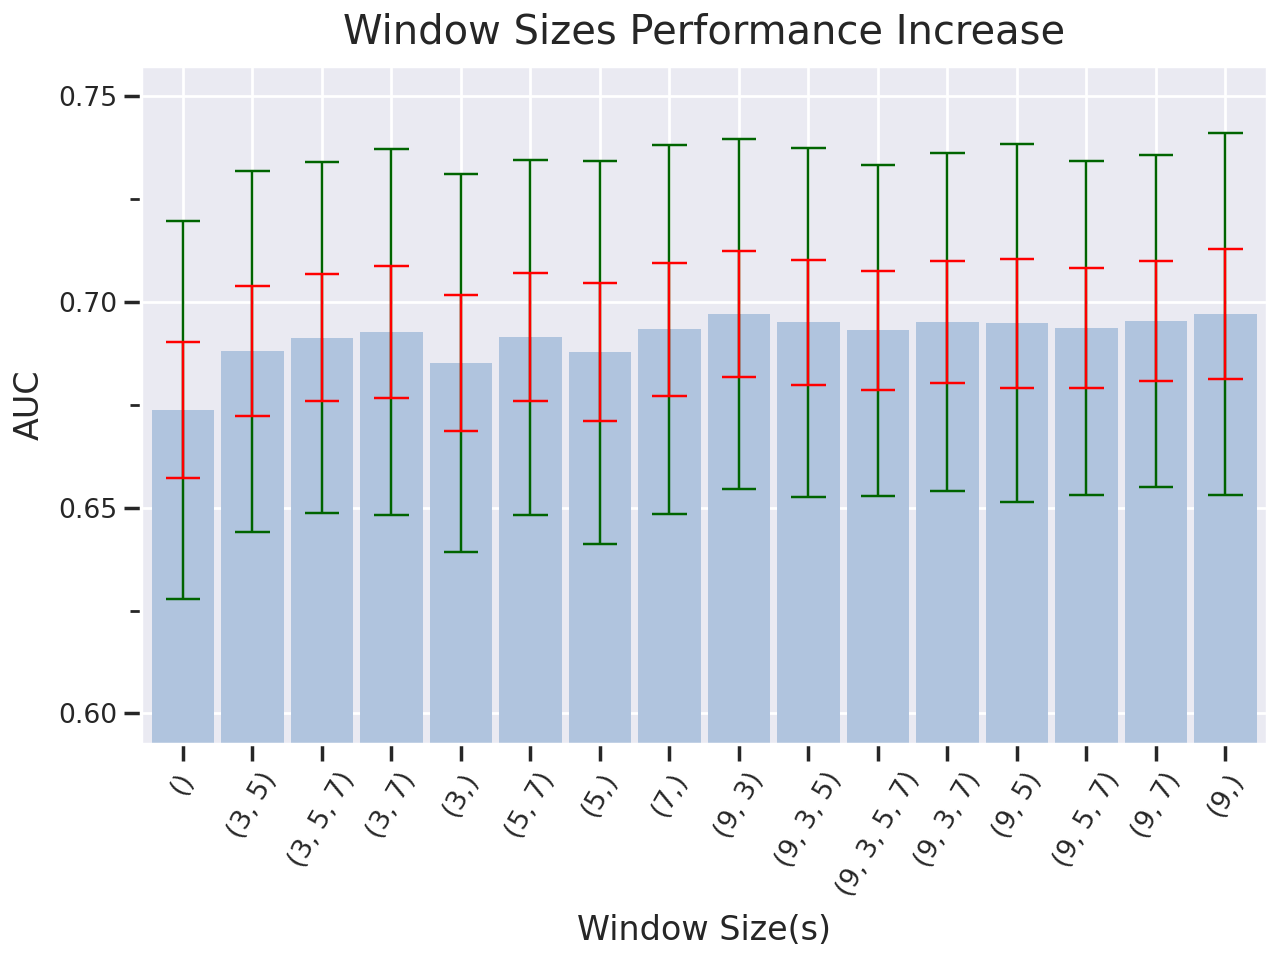

In [54]:
from plotnine import ggplot, aes, geom_bar, geom_errorbar, labs, theme_seaborn, coord_cartesian, theme, element_text

def plot_window_performance(df: pd.DataFrame, best_score_metric: str, title: str, n_folds: int=5) -> None:
	import scipy.stats as stats
	confidence = 0.95
	t_critical = stats.t.ppf((1 + confidence) / 2, df=n_folds - 1)
	df = df.rename({'best_score': best_score_metric}, axis=1)

	df['SEM'] = df['stdev'] / n_folds**0.5
	df['CI'] = t_critical * df['SEM']

	# Create ggplot
	p = (
		ggplot(df, aes(x='windows', y=best_score_metric)) +
		geom_bar(stat='identity', position='dodge', show_legend=True, fill='LightSteelBlue') +  # Bar plot
		labs(title=title, y=best_score_metric.upper(), x='Window Size(s)') +
		geom_errorbar(aes(ymin=f'{best_score_metric} - CI', ymax=f'{best_score_metric} + CI'), color='darkgreen') +
		geom_errorbar(aes(ymin=f'{best_score_metric} - SEM', ymax=f'{best_score_metric} + SEM'), color='red') +
		coord_cartesian(ylim=(0.6,0.75)) +
		theme_seaborn() +
		theme(axis_text_x=element_text(rotation=60, hjust=0.5))
	)

	display(p)

plot_window_performance(hyperparam_results, 'auc', 'Window Sizes Performance Increase')
# Performance increase is insignificant, however, performance is consistently better with window sizes
# This is possibly because no window size (or window size 1) encodes most of the valuable information (hence the insignificant increase)
# But the consistent higher score implies that there is some valuable information that the no window size does not have

In [55]:
from typing import OrderedDict

result_file_control = 'results_0'
result_file_test = 'results_09'

X_0 = select_window_sizes(X_non_windowed, [])
X_09 = select_window_sizes(X_non_windowed, [9])

print(hyperparam_results.iloc[0, 2])  # Size ()
hyperparams_0 = {'criterion': 'gini', 'max_depth': 29, 'max_features': 'log2', 'min_samples_leaf': 67, 'n_estimators': 285}
print(hyperparam_results.iloc[1, 2])  # Size (9,)
hyperparams_09 = {'criterion': 'gini', 'max_depth': 45, 'max_features': 'log2', 'min_samples_leaf': 67, 'n_estimators': 300}

model_0 = RandomForestClassifier(class_weight='balanced', n_jobs=-1, **hyperparams_0)
model_09 = RandomForestClassifier(class_weight='balanced', n_jobs=-1, **hyperparams_09)

if not os.path.exists(f'./data/{result_file_control}.csv') or not os.path.exists(f'./data/{result_file_control}.csv'):
	print('Running 0 model...')
	results_0 = kfold_cv_by_group(X_0, y, groups, model_0, n_splits=50)
	results_0.to_csv(f'./data/{result_file_control}.csv', index=False)
	print('Running 09 model...')
	results_09 = kfold_cv_by_group(X_09, y, groups, model_09, n_splits=50)
	results_09.to_csv(f'./data/{result_file_test}.csv', index=False)
else:
	results_0 = hyperparam_results = pd.read_csv(f'./data/{result_file_control}.csv')
	results_09 = hyperparam_results = pd.read_csv(f'./data/{result_file_test}.csv')

Intersection:  frozenset({'hydrophobicity_scores', 'pssm_R', 'pssm_V', 'pssm_W', 'pssm_D', 'normalized_hydropathy_index', 'pssm_E', 'normalized_abs_surf_acc', 'rel_surf_acc', 'prob_helix', 'pssm_C', 'pssm_P', 'pssm_I', 'pssm_N', 'pssm_T', 'pssm_F', 'pssm_H', 'pssm_Y', 'pssm_S', 'prob_sheet', 'normalized_length', 'pssm_Q', 'pssm_K', 'Rlength', 'prob_coil', 'pssm_M', 'pssm_L', 'pssm_A', 'pssm_G'})
Intersection:  frozenset({'hydrophobicity_scores', 'pssm_R', 'pssm_V', '9_wm_pssm_Y', 'pssm_W', '9_wm_normalized_hydropathy_index', '9_wm_pssm_D', 'pssm_D', '9_wm_pssm_T', 'normalized_hydropathy_index', 'pssm_E', 'normalized_abs_surf_acc', '9_wm_pssm_G', 'rel_surf_acc', '9_wm_pssm_M', 'prob_helix', 'pssm_C', 'pssm_P', '9_wm_prob_sheet', '9_wm_rel_surf_acc', '9_wm_pssm_H', '9_wm_normalized_abs_surf_acc', 'pssm_I', 'pssm_N', 'pssm_T', '9_wm_pssm_N', 'pssm_H', 'pssm_F', '9_wm_pssm_F', '9_wm_pssm_K', '9_wm_pssm_W', 'pssm_Y', 'pssm_S', 'prob_sheet', 'normalized_length', '9_wm_prob_coil', 'pssm_Q', '

In [56]:
X_9 = select_window_size(X_non_windowed, 9)

results_file_hyperparam_9 = 'results_hyperparam_9'

gs_params = {
    'max_depth': list(range(5, 51)),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': list(range(1, 73, 2)),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': list(range(5, 301, 5))
}
if not os.path.exists(f'./data/{results_file_hyperparam_9}.csv'):
	print('Running hyperparmeter optimization...')
	gridsearch = BayesSearchCV(gs_model, gs_params, n_jobs=-1, scoring='roc_auc', cv=GroupKFold())
	dict_results = {'size': [], 'windows': [], 'best_params': [], 'best_score': [], 'stdev': []}
	gridsearch.fit(X_9, y, groups=groups)
	dict_results['size'].append(size)
	dict_results['windows'].append(selection)
	dict_results['best_params'].append(gridsearch.best_params_)
	dict_results['best_score'].append(gridsearch.best_score_)
	dict_results['stdev'].append(gridsearch.cv_results_['std_test_score'][gridsearch.best_index_])
			
	hyperparam_results = pd.DataFrame(dict_results).sort_values('best_score', ascending=False)
	hyperparam_results.to_csv(f'./data/{results_file_hyperparam_9}.csv', index=False)
else:
	hyperparam_results = pd.read_csv(f'./data/{results_file_hyperparam_9}.csv')

# If there is an error here, it is most likely because Pandas is shit at importing complex data types
print(hyperparam_results.iloc[0, 2])
result_file_single = 'results_9'
hyperparams_9 = {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 67, 'n_estimators': 50}
model_9 = RandomForestClassifier(class_weight='balanced', n_jobs=-1, **hyperparams_9)

if not os.path.exists(f'./data/{result_file_single}.csv'):
	print('Running 0 model...')
	results_9 = kfold_cv_by_group(X_9, y, groups, model_9, n_splits=50)
	results_9.to_csv(f'./data/{result_file_single}.csv', index=False)
else:
	results_9 = hyperparam_results = pd.read_csv(f'./data/{result_file_single}.csv')

# For multiple windows:
# 	frozenset({'prob_coil', 'pssm_R', 'pssm_A', 'pssm_F', 'pssm_K', 'pssm_I', 'pssm_N', 'normalized_length', 'pssm_G', 'hydrophobicity_scores', 'rel_surf_acc', 'prob_sheet', 'prob_helix', 'Rlength', 'pssm_Q', 'pssm_Y', 'pssm_L', 'pssm_T', 'pssm_P', 'pssm_V', 'pssm_W', 'pssm_C', 'normalized_hydropathy_index', 'pssm_E', 'pssm_H', 'pssm_D', 'pssm_M', 'pssm_S', 'normalized_abs_surf_acc'})

Intersection:  frozenset({'hydrophobicity_scores', '9_wm_pssm_Y', '9_wm_normalized_hydropathy_index', '9_wm_pssm_D', '9_wm_pssm_T', '9_wm_pssm_G', '9_wm_pssm_M', '9_wm_prob_sheet', '9_wm_pssm_H', '9_wm_rel_surf_acc', '9_wm_normalized_abs_surf_acc', '9_wm_pssm_N', '9_wm_pssm_F', '9_wm_pssm_K', '9_wm_pssm_W', 'normalized_length', '9_wm_prob_coil', 'Rlength', '9_wm_pssm_C', '9_wm_pssm_V', '9_wm_pssm_Q', '9_wm_prob_helix', '9_wm_pssm_A', '9_wm_pssm_R', '9_wm_pssm_L', '9_wm_pssm_I', '9_wm_pssm_S', '9_wm_pssm_P', '9_wm_pssm_E'})
OrderedDict({'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 67, 'n_estimators': 50})


/home/jacobr/Documents/Masters/MSc_SML/scientific-machine-learning-project/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


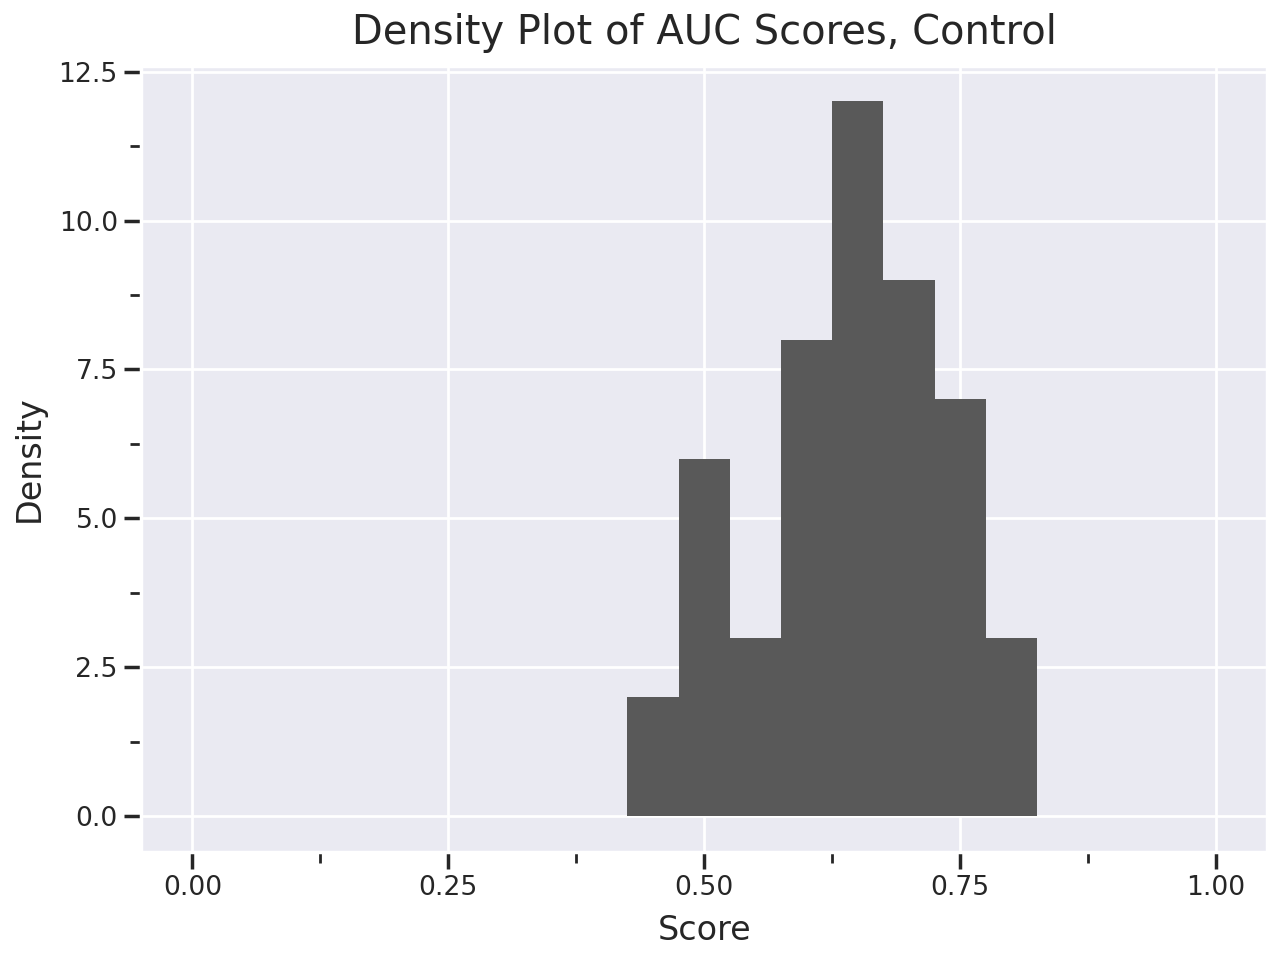

/home/jacobr/Documents/Masters/MSc_SML/scientific-machine-learning-project/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


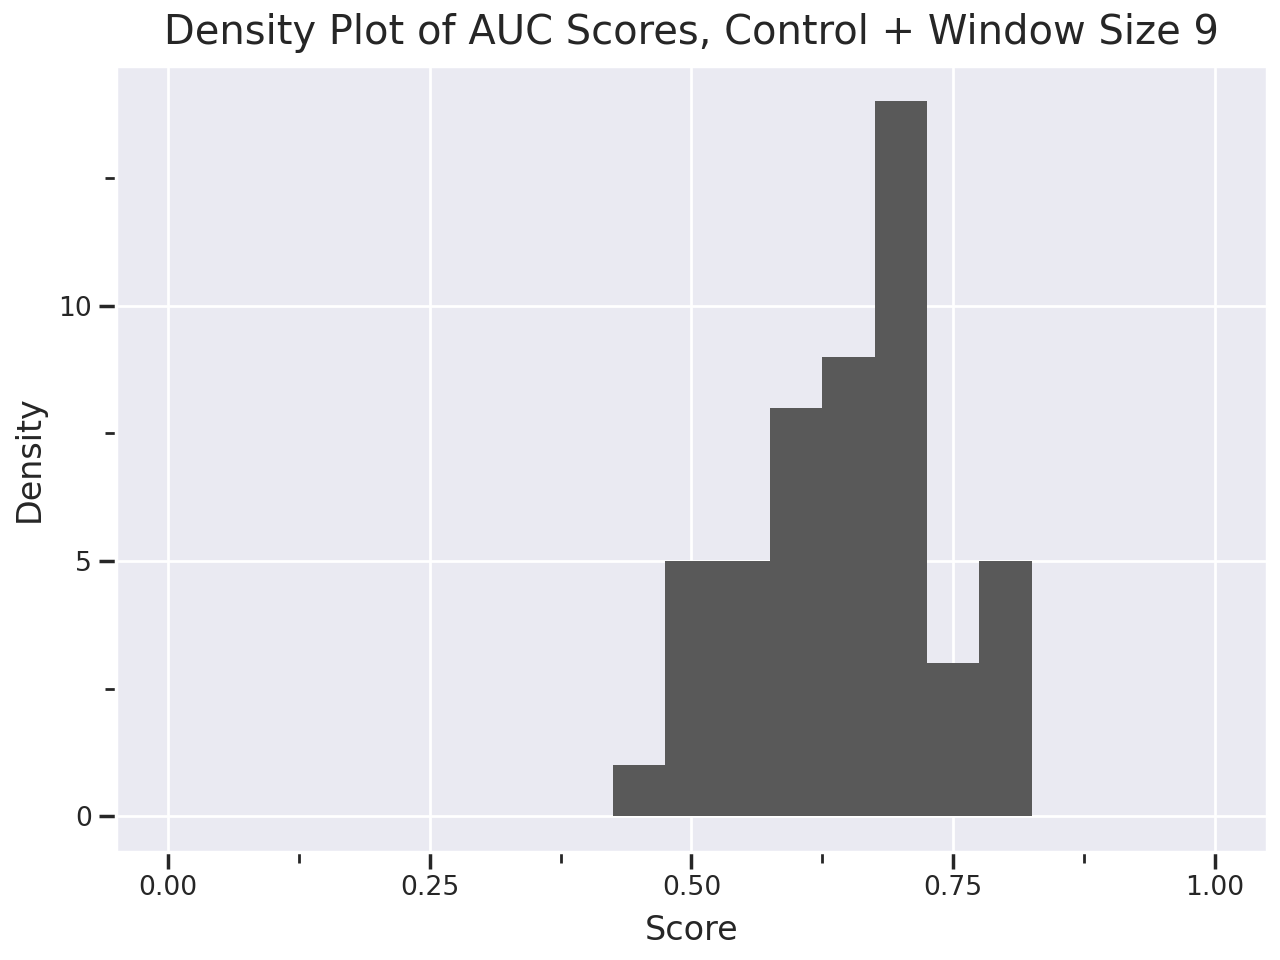

/home/jacobr/Documents/Masters/MSc_SML/scientific-machine-learning-project/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


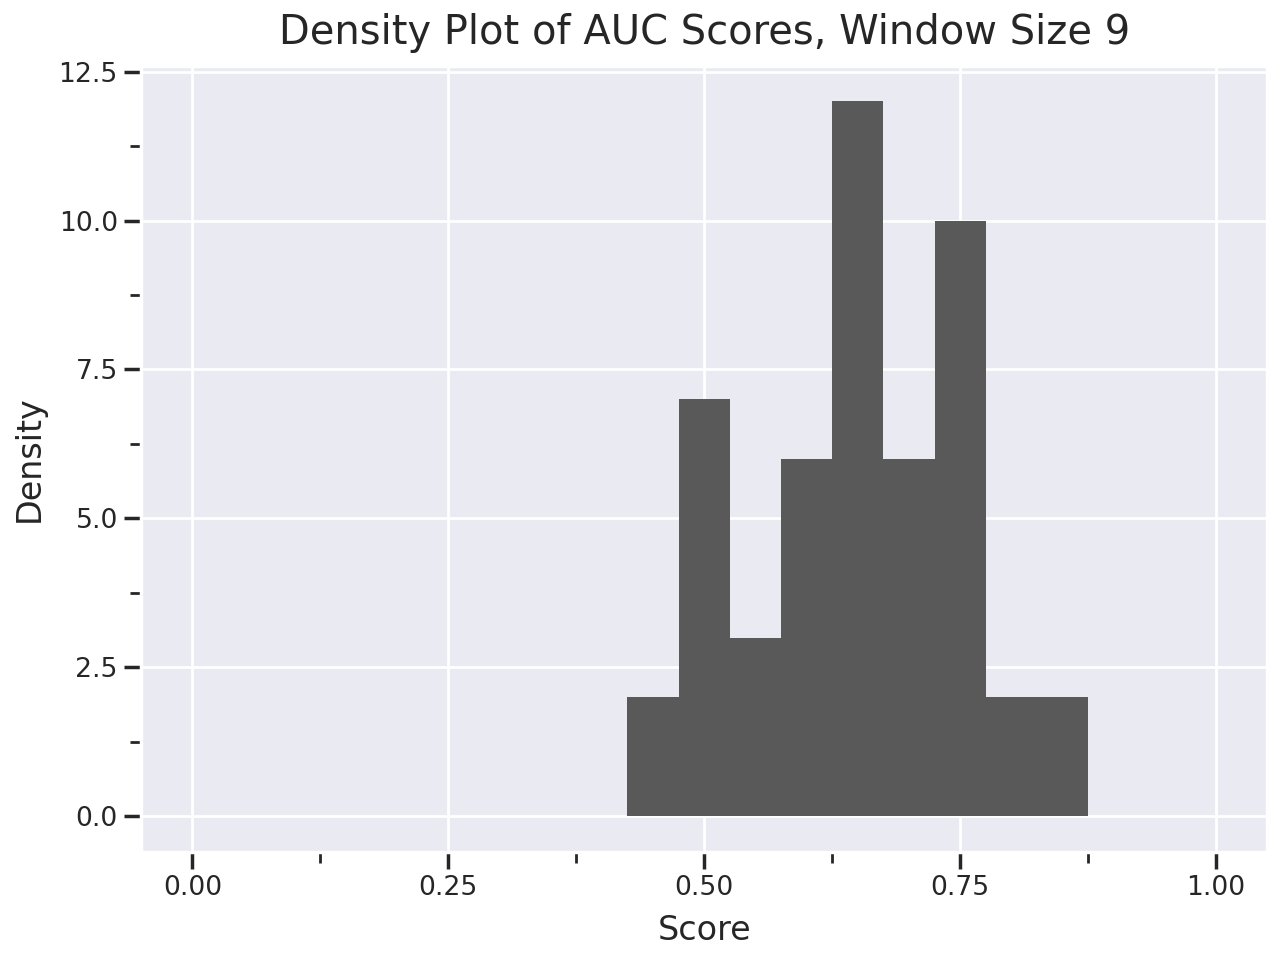

/home/jacobr/Documents/Masters/MSc_SML/scientific-machine-learning-project/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


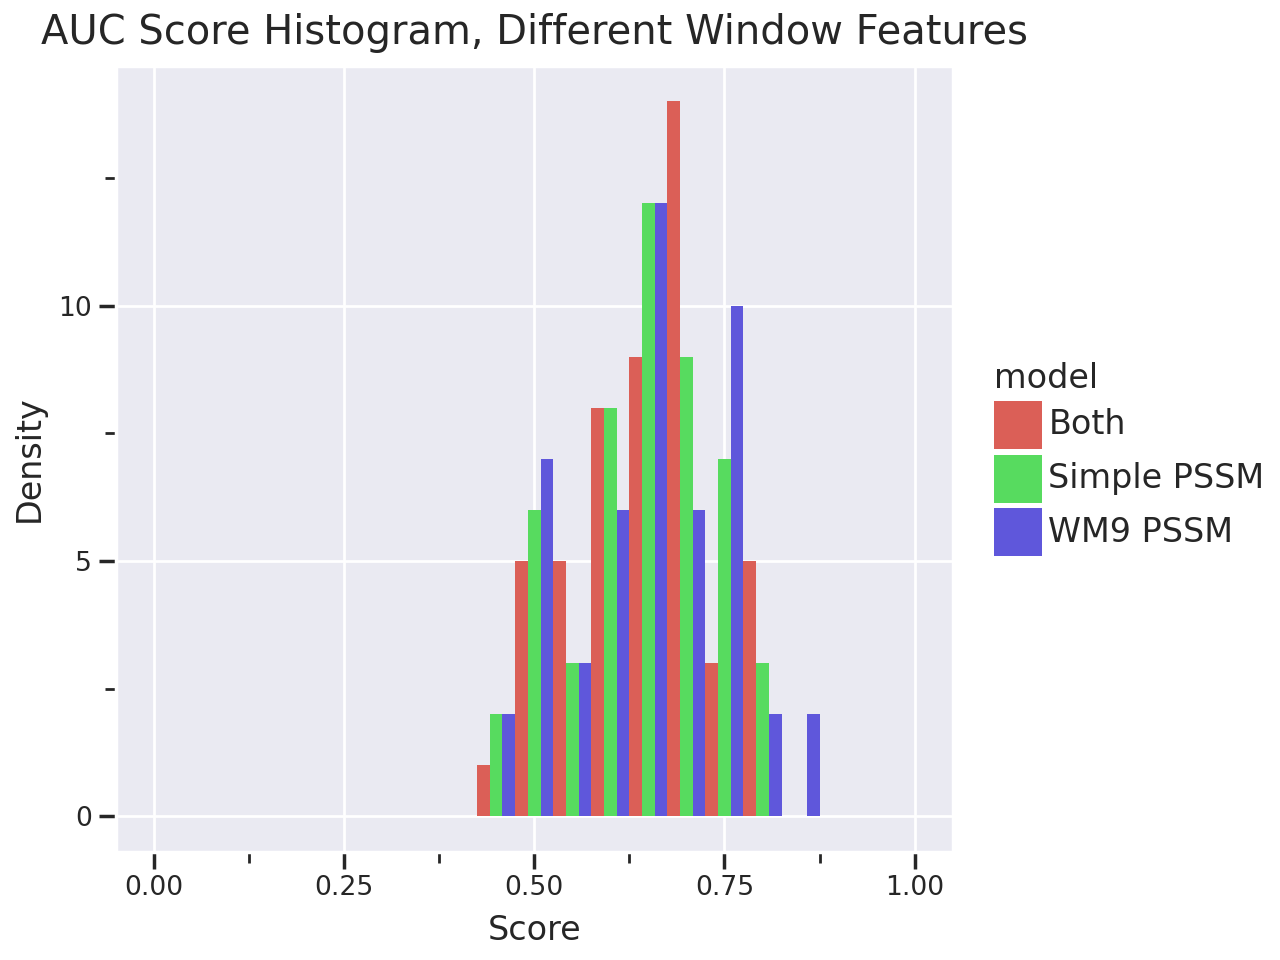

In [108]:
from plotnine import ggplot, aes, geom_bar, geom_errorbar, labs, theme_seaborn, ylim, xlim, facet_wrap, geom_density, geom_histogram
# Create density plot using plotnine
def plot_density(df: pd.DataFrame, title: str, score: str='auc', x_limit: tuple[int, int]=(0, 1), **kwargs):
    plot = (ggplot(df, aes(x=score)) +
		geom_histogram(**kwargs) +  # Add density plot with transparency
		theme_seaborn() +
		labs(title=title, x='Score', y='Density') +
		xlim(x_limit))
    return plot

def plot_densities(dfs: list[pd.DataFrame], title: str, score: str='auc', x_limit: tuple[int, int]=(0, 1), **kwargs):
	df = pd.concat(dfs)
	plot = (ggplot(df, aes(x=score, fill='model')) +
        geom_histogram(position='dodge', **kwargs) +
		theme_seaborn() +
		labs(title=title, x='Score', y='Density') +
		xlim(x_limit))
	return plot

results_0.loc[:, 'model'] = 'Simple PSSM'
results_09.loc[:, 'model'] = 'Both'
results_9.loc[:, 'model'] = 'WM9 PSSM'

display(plot_density(results_0, 'Density Plot of AUC Scores, Control', binwidth=0.05))
display(plot_density(results_09, 'Density Plot of AUC Scores, Control + Window Size 9', binwidth=0.05))
display(plot_density(results_9, 'Density Plot of AUC Scores, Window Size 9', binwidth=0.05))

display(plot_densities([results_0, results_9, results_09], 'AUC Score Histogram, Different Window Features', binwidth=0.05))

In [119]:
def plot_performance(dfs: list[pd.DataFrame], model_names: list[str], score_names: list, title: str='', y_limit=(0, 1), is_normally_distributed: bool=True, verbose: bool=False) -> None:
	import scipy.stats as stats
	confidence = 0.95
	dfs_long: list[pd.DataFrame] = []
	for df, model_name in zip(dfs, model_names):
		n = df.shape[0]
		t_critical = stats.t.ppf((1 + confidence) / 2, df=n - 1)
		if verbose: display(df)

		df_long = df.melt(value_vars=score_names, var_name='Metric', value_name='Score')
		score_means = df[score_names].mean()
		score_sem = df[score_names].sem()
		if is_normally_distributed:
			score_ci_upper = t_critical * score_sem
			score_ci_lower = t_critical * score_sem
		score_summary = pd.DataFrame({
			'Metric': score_means.index,
			'Mean': score_means.values,
			'SEM': score_sem.values,
			'UpperCI': score_ci_upper.values,
			'LowerCI': score_ci_lower.values
		})
		if verbose: display(score_summary)
		df_long = df_long.merge(score_summary, on='Metric', how='left')
		df_long.loc[:, 'Model'] = model_name
		dfs_long.append(df_long)
	df_long = pd.concat(dfs_long, ignore_index=True)
	if verbose: display(df_long)

	# Create ggplot
	p = (
		ggplot(df_long, aes(x='Model', y='Mean', fill='Metric')) +
		geom_bar(stat='identity', position='dodge', show_legend=True) +  # Bar plot
		labs(title=title, y="Score", x="Metric") +
		geom_errorbar(aes(ymin='Mean - LowerCI', ymax='Mean + UpperCI'), color='darkgreen') +
		geom_errorbar(aes(ymin='Mean - SEM', ymax='Mean + SEM'), color='red') +
		coord_cartesian(y_lim=y_limit) +
		theme_seaborn() +
		theme(axis_text_x=element_text(rotation=90, hjust=0.5)) +
		facet_wrap('Metric')
	)

	display(p)

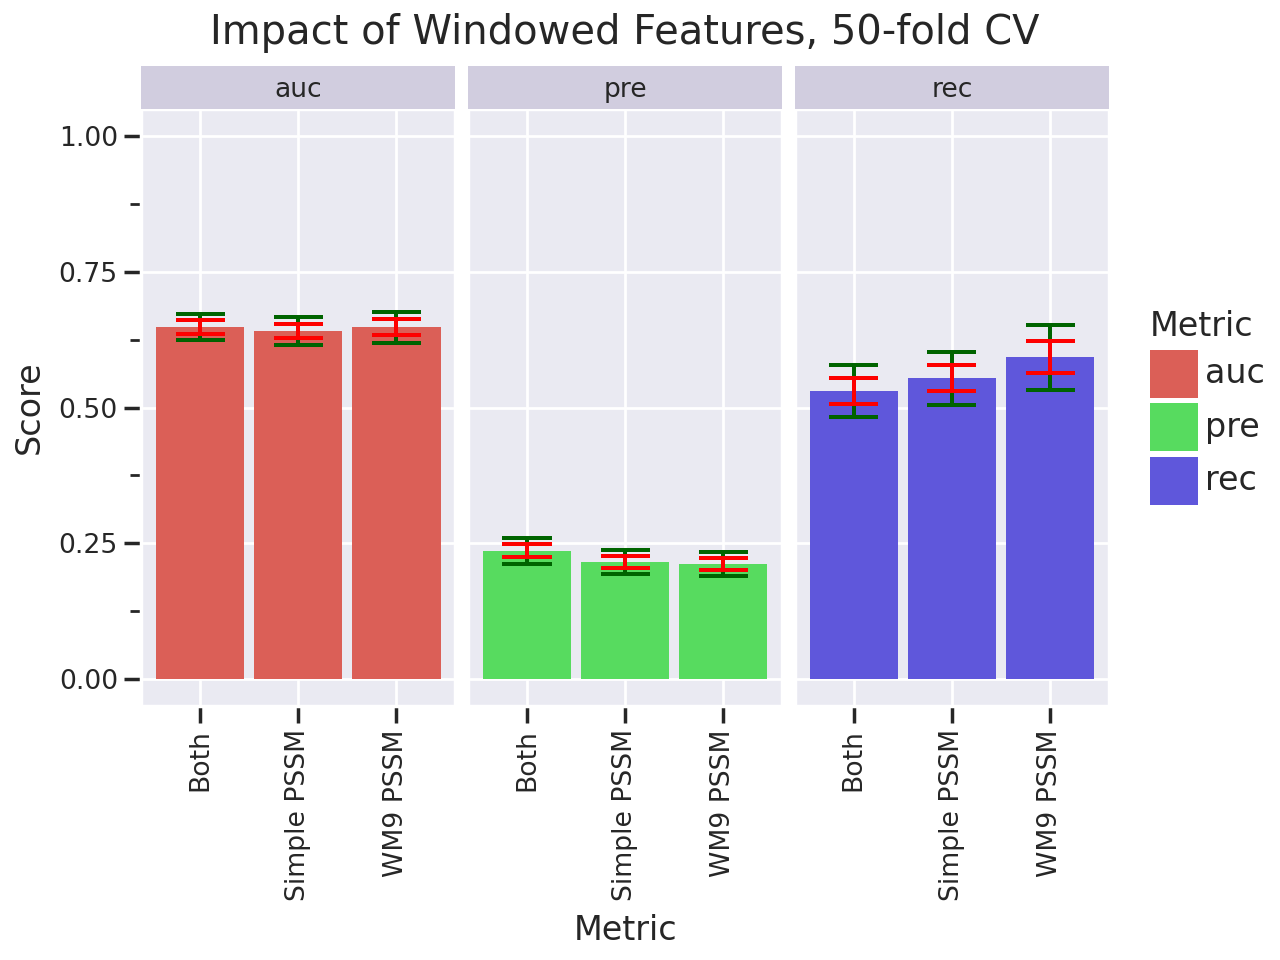

In [114]:
plot_performance([results_0, results_09, results_9], ['Simple PSSM', 'Both', 'WM9 PSSM'], ['auc', 'rec', 'pre'], 'Impact of Windowed Features, 50-fold CV')

# SEM overlaps!

In [68]:
y_train = ppi_clean.p_interface
X_train = ppi_clean.drop('p_interface', axis=1)
X_train = remove_non_features(X_train, non_feature_cols)

X_train_0 = select_window_sizes(X_train, [])
X_train_09 = select_window_sizes(X_train, [9])
X_train_9 = select_window_size(X_train, 9)
X_trains = [X_train_0, X_train_09, X_train_9]

ppi_clean_test = pd.read_csv('./data/ppi_clean_test.csv')

y_test = ppi_clean_test.p_interface
X_test = ppi_clean_test.drop('p_interface', axis=1)
X_test = remove_non_features(X_test, non_feature_cols)

X_test_0 = select_window_sizes(X_test, [])
X_test_09 = select_window_sizes(X_test, [9])
X_test_9 = select_window_size(X_test, 9)
X_tests = [X_test_0, X_test_09, X_test_9]

# These models are quite fast to train, so I decided not to save the data...
model_0 = RandomForestClassifier(class_weight='balanced', n_jobs=-1, **hyperparams_0)
model_09 = RandomForestClassifier(class_weight='balanced', n_jobs=-1, **hyperparams_09)
model_9 = RandomForestClassifier(class_weight='balanced', n_jobs=-1, **hyperparams_9)
models = [model_0, model_09, model_9]

y_predictions = []
for m, X_tr, X_te in zip(models, X_trains, X_tests):
    m.fit(X_tr, y_train)
    y_pred = m.predict_proba(X_te)[:, 1]
    y_predictions.append(y_pred)

Intersection:  frozenset({'hydrophobicity_scores', 'pssm_R', 'pssm_V', 'pssm_W', 'pssm_D', 'normalized_hydropathy_index', 'pssm_E', 'normalized_abs_surf_acc', 'rel_surf_acc', 'prob_helix', 'pssm_C', 'pssm_P', 'pssm_I', 'pssm_N', 'pssm_T', 'pssm_F', 'pssm_H', 'pssm_Y', 'pssm_S', 'prob_sheet', 'normalized_length', 'pssm_Q', 'pssm_K', 'Rlength', 'prob_coil', 'pssm_M', 'pssm_L', 'pssm_A', 'pssm_G'})
Intersection:  frozenset({'hydrophobicity_scores', 'pssm_R', 'pssm_V', '9_wm_pssm_Y', 'pssm_W', '9_wm_normalized_hydropathy_index', '9_wm_pssm_D', 'pssm_D', '9_wm_pssm_T', 'normalized_hydropathy_index', 'pssm_E', 'normalized_abs_surf_acc', '9_wm_pssm_G', 'rel_surf_acc', '9_wm_pssm_M', 'prob_helix', 'pssm_C', 'pssm_P', '9_wm_prob_sheet', '9_wm_rel_surf_acc', '9_wm_pssm_H', '9_wm_normalized_abs_surf_acc', 'pssm_I', 'pssm_N', 'pssm_T', '9_wm_pssm_N', 'pssm_H', 'pssm_F', '9_wm_pssm_F', '9_wm_pssm_K', '9_wm_pssm_W', 'pssm_Y', 'pssm_S', 'prob_sheet', 'normalized_length', '9_wm_prob_coil', 'pssm_Q', '

In [ ]:
# Bootstrapping
import numpy as np
from sklearn.utils import resample
from itertools import repeat

def bootstrap_metrics(y_true: list[float], y_pred: list[float], metric_funcs: list[object], metrics: list[str], n_bootstraps=5000) -> pd.DataFrame:
	"""Bootstrap the given metric to compute confidence intervals."""
	y_true = np.array(y_true)
	y_pred = np.array(y_pred)
	score_dict = {metric: [] for metric in metrics}
    
	for _ in repeat(None, n_bootstraps):
		indices = resample(range(len(y_true)), replace=True)

		for metric_func, metric in zip(metric_funcs, metrics):
			if metric != 'AUC':
				y_pred = np.round(y_pred)
			score = metric_func(y_true[indices], y_pred[indices])
			score_dict[metric].append(score)
	
	for metric in metrics:
		sorted_scores = np.array(score_dict[metric])
		sorted_scores.sort()
		confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
		confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
		print("Confidence interval for {}: [{:0.3f} - {:0.3}]".format(
			metric, confidence_lower, confidence_upper))

	df_result = pd.DataFrame(score_dict)
	return df_result

metric_funcs = [roc_auc_score, precision_score, recall_score]
test_res_0 = bootstrap_metrics(y_test, y_predictions[0], metric_funcs, ['AUC', 'Pre', 'Rec'])
test_res_0.loc[:, 'model'] = 'Simple PSSM'
test_res_09 = bootstrap_metrics(y_test, y_predictions[1], metric_funcs, ['AUC', 'Pre', 'Rec'])
test_res_09.loc[:, 'model'] = 'Both'
test_res_9 = bootstrap_metrics(y_test, y_predictions[2], metric_funcs, ['AUC', 'Pre', 'Rec'])
test_res_9.loc[:, 'model'] = 'WM9 PSSM'

Confidence interval for AUC: [0.627 - 0.649]
Confidence interval for Pre: [0.186 - 0.206]
Confidence interval for Rec: [0.544 - 0.588]
Confidence interval for AUC: [0.631 - 0.653]
Confidence interval for Pre: [0.197 - 0.219]
Confidence interval for Rec: [0.520 - 0.562]
Confidence interval for AUC: [0.635 - 0.657]
Confidence interval for Pre: [0.181 - 0.199]
Confidence interval for Rec: [0.604 - 0.646]


/home/jacobr/Documents/Masters/MSc_SML/scientific-machine-learning-project/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


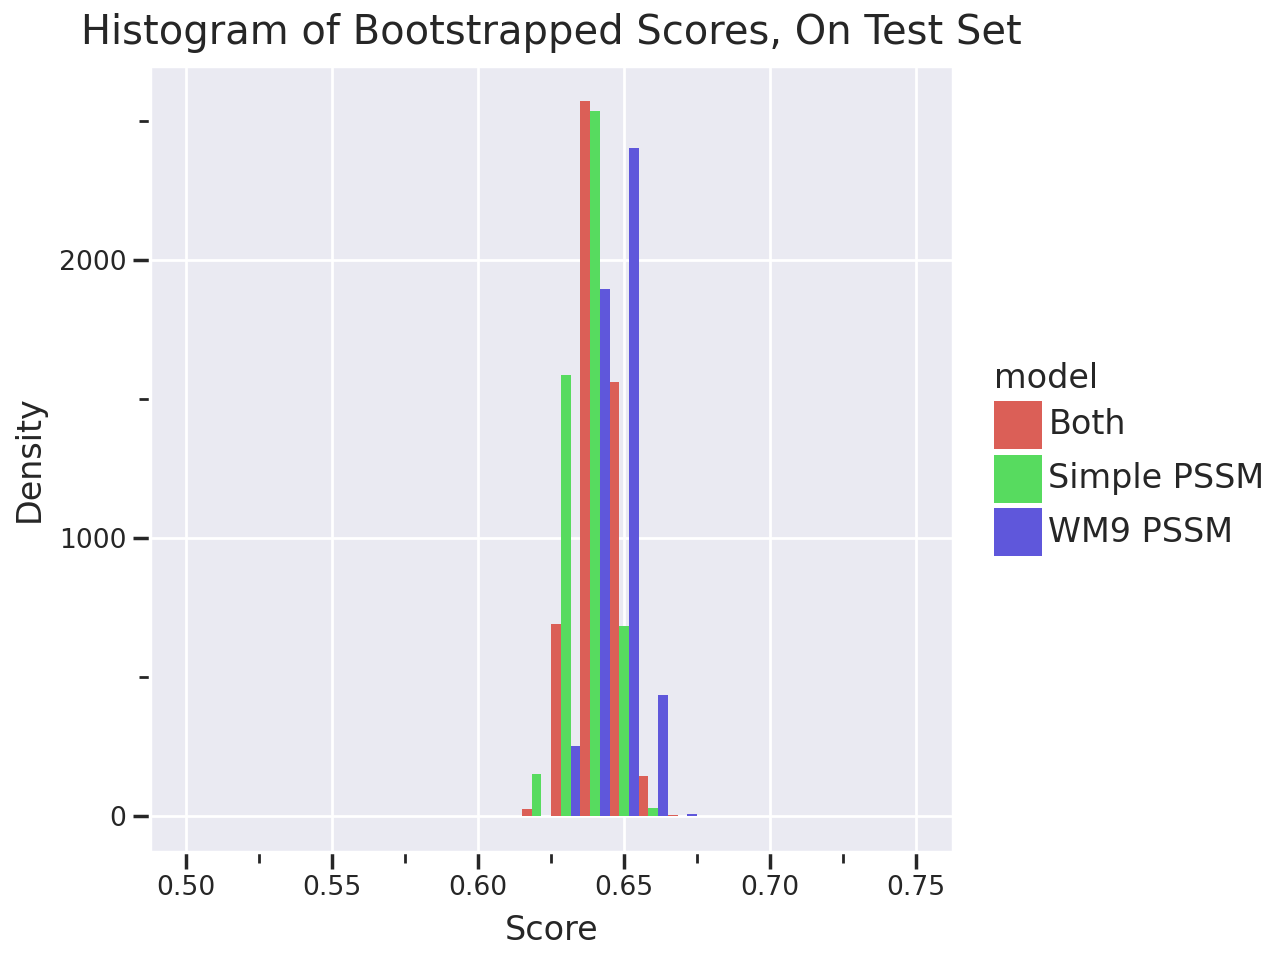

In [120]:
plot_densities([test_res_0, test_res_09, test_res_9], 'Histogram of Bootstrapped Scores, On Test Set', 'AUC', (0.5, 0.75), binwidth=0.01)

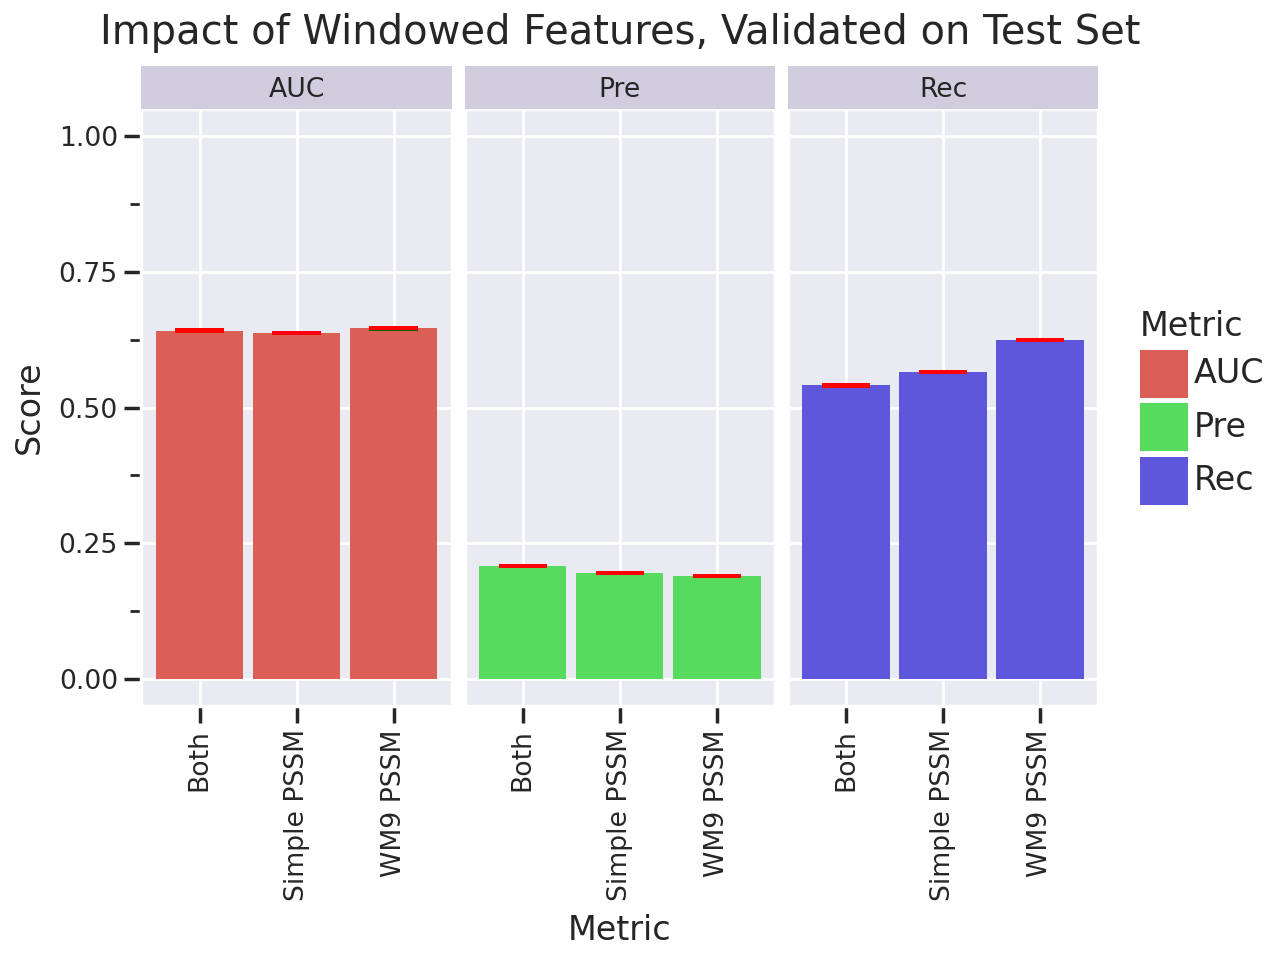

In [118]:
plot_performance([test_res_0, test_res_09, test_res_9], ['Simple PSSM', 'Both', 'WM9 PSSM'], ['AUC', 'Pre', 'Rec'], 'Impact of Windowed Features, Validated on Test Set')